In [19]:
import pandas as pd
import os
import yaml
import torch
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.pyplot.rcParams['figure.figsize'] = (15, 6)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

In [2]:
def compute_sparsity(model_fn, threshold=10e-3):
    is_zero = 0
    non_zero = 0
    for name, tensor in torch.load(model_fn).items():
        m = tensor.cpu().numpy()
        close = len(np.where(np.abs(m) <= threshold)[0])
        is_zero += close
        non_zero += (m.size - close)
    return is_zero, non_zero, is_zero / (is_zero + non_zero)
    
    
def get_min_loss(row):
    min_idx, min_val_loss = min(enumerate(row['dev_loss']), key=lambda x: x[1])
    min_train_loss = row['train_loss'][min_idx]
    row['min_val_loss'] = min_val_loss
    row['min_train_loss'] = min_train_loss
    return row
    
    
def load_res_dir(basedir):
    experiments = []
    for subdir in os.scandir(basedir):
        exp_d = {}
        with open(os.path.join(subdir.path, "config.yaml")) as f:
            exp_d.update(yaml.load(f))
        res_fn = os.path.join(subdir.path, "result.yaml")
        if os.path.exists(res_fn):
            with open(os.path.join(subdir.path, "result.yaml")) as f:
                exp_d.update(yaml.load(f))
        else:
            continue
        dev_acc_path = os.path.join(subdir.path, "dev.word_accuracy")
        if os.path.exists(dev_acc_path):
            with open(dev_acc_path) as f:
                exp_d['dev_acc'] = float(f.read())
        else:
            print("Dev accuracy file does not exist in dir: {}".format(subdir.path))
        exp_d['sparsity'] = compute_sparsity(os.path.join(subdir.path, "model"), 10e-4)
        experiments.append(exp_d)
    experiments = pd.DataFrame(experiments)
    experiments['sparsity_ratio'] = experiments['sparsity'].apply(lambda x: x[2])
    experiments['language'] = experiments.dev_file.apply(lambda s: s.split("/")[-1].split("-")[0])
    experiments = experiments.apply(get_min_loss, axis=1)
    experiments = experiments[experiments['dev_acc'].notnull()]
    experiments = experiments[experiments['dev_loss'].notnull()]
    return experiments

In [3]:
experiments = load_res_dir("../exps/reinflection_ron")
exps2 = load_res_dir("../exps/reinflection")

experiments = pd.concat([experiments, exps2], axis=0)

Dev accuracy file does not exist in dir: ../exps/reinflection/0177
Dev accuracy file does not exist in dir: ../exps/reinflection/0178


# Language distribution

I did run a few experiments on Hungarian.

In [4]:
experiments.language.value_counts()

hungarian    191
basque        11
finnish       10
welsh          5
Name: language, dtype: int64

## Highest dec accuracy per language

In [5]:
experiments.groupby('language').max()['dev_acc'].to_frame()

,dev_acc
language,
basque,0.987
finnish,0.914
hungarian,0.850
welsh,0.960


# Filter non-Hungarian experiments

In [6]:
experiments = experiments[experiments.language=="hungarian"]

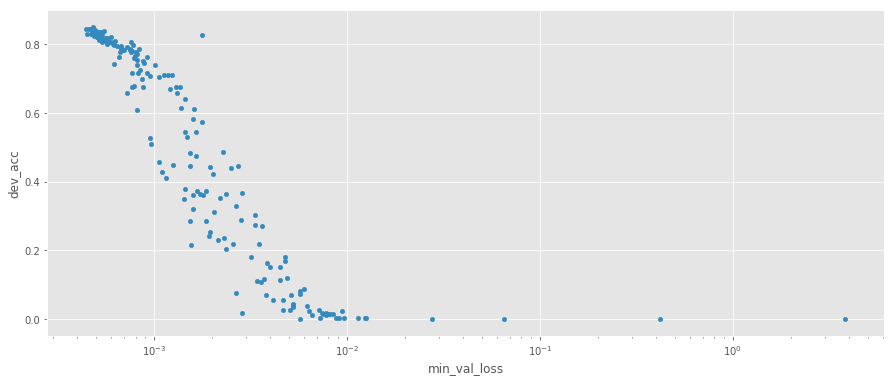

In [20]:
experiments.plot(kind='scatter', x='min_val_loss', y='dev_acc', logx=True)

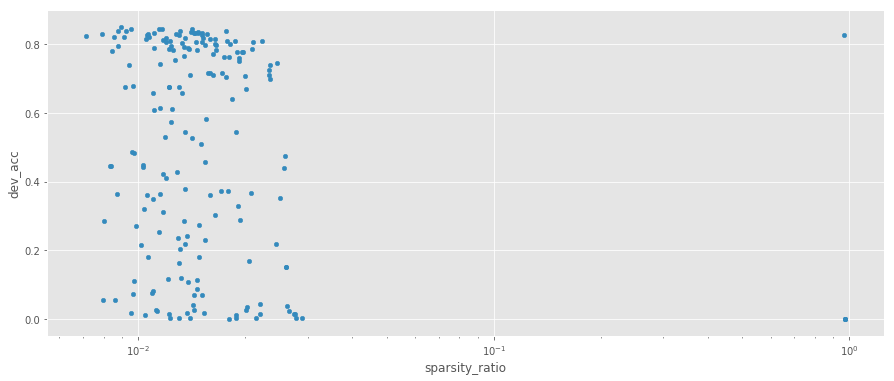

In [21]:
experiments.plot(kind='scatter', x='sparsity_ratio', logx=True, y='dev_acc')

In [9]:
hun = experiments[experiments.language=="hungarian"].copy()
hun.loc[hun['dev_acc'].idxmax()]['experiment_dir']

'/mnt/permanent/home/judit/projects/deep-morphology/exps/reinflection/0078'

In [10]:
lemma_params = [c for c in hun.columns if c.startswith('lemma')]
tag_params = [c for c in hun.columns if c.startswith('tag')]
inflected_params = [c for c in hun.columns if c.startswith('inflected')]
other_params = ['dropout']
params = lemma_params + tag_params + inflected_params + other_params

hun.loc[hun['dev_acc'].idxmax()].loc[params]

lemma_embedding_size         20
lemma_hidden_size           128
lemma_num_layers              3
tag_embedding_size           10
tag_hidden_size              64
tag_num_layers                2
inflected_embedding_size     30
inflected_hidden_size       128
inflected_num_layers          2
dropout                     0.2
Name: 77, dtype: object

In [11]:
hun['lemma_neurons'] = hun['lemma_num_layers'] * hun['lemma_hidden_size']
hun['tag_neurons'] = hun['tag_num_layers'] * hun['tag_hidden_size']
hun['inflected_neurons'] = hun['inflected_num_layers'] * hun['inflected_hidden_size']
hun['sum_neurons'] = hun['lemma_neurons'] + hun['tag_neurons'] + hun['inflected_neurons']

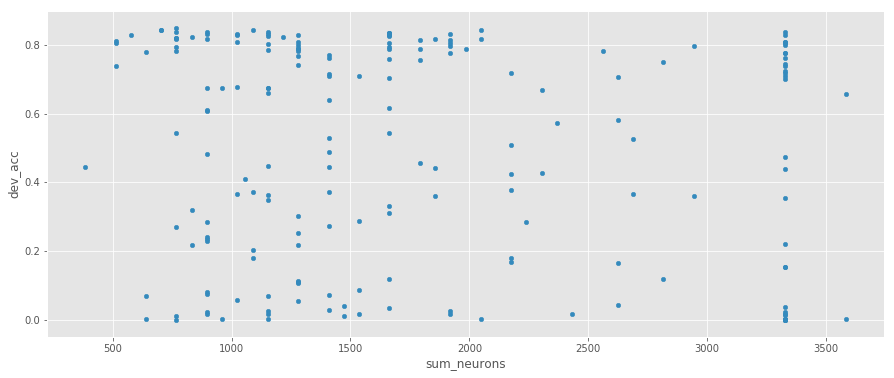

In [22]:
hun.plot(kind='scatter', x='sum_neurons', y='dev_acc')

In [13]:
hun.groupby('dropout').max()['dev_acc']

dropout
0.0    0.833
0.2    0.850
0.5    0.843
0.8    0.545
Name: dev_acc, dtype: float64

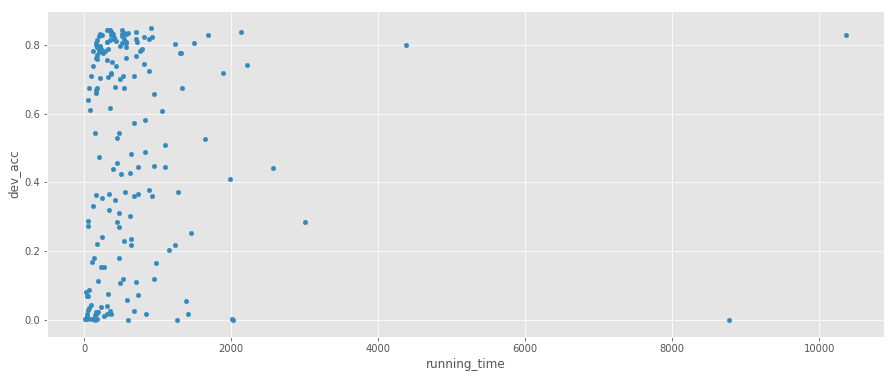

In [23]:
hun.plot(kind='scatter', x='running_time', y='dev_acc')

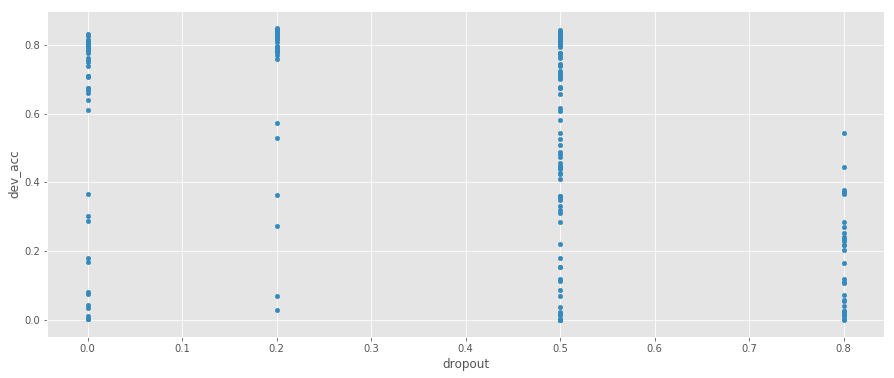

In [24]:
hun.plot(kind='scatter', x='dropout', y='dev_acc')

# Sparse models

L1 regularization

In [16]:
l1_reg_models = load_res_dir("../exps/sigmorphon_2018/l1_reg/")

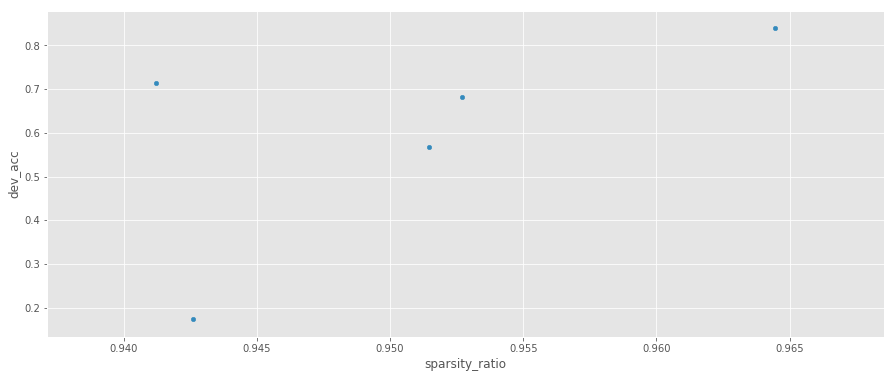

In [25]:
l1_reg_models.plot(kind='scatter', x='sparsity_ratio', y='dev_acc')